# From Theory to Practice: Unlocking the Distribution of Capacitive Times for Electrochemical Impedance Spectroscopy

In this tutorial, we will show how two use the two deep neural networks (DNNs) described in the article to analyze five artifical EIS spectra generated using de Levie model (Section 3.2.1.2).

In [1]:
# import the libraries needed
import os
import numpy as np
import importlib
import compute_DCT
importlib.reload(compute_DCT)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import ListedColormap
from matplotlib import gridspec

In [2]:
# additional verifications
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,3), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,3), 'MB')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# seed for reproducibility
torch.manual_seed(213912)

Using device: cpu


In [3]:
# plot standards
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Generate the artificial data

## 1.1 Define the ranges of EIS frequencies and timescales

In [4]:
# range of frequencies
N_freqs = 91
freq_min = 10**-3
freq_max = 10**6
freq_vec = np.logspace(np.log10(freq_min), np.log10(freq_max), num=N_freqs, endpoint=True)
freq_vec_torch = torch.from_numpy(freq_vec[:, np.newaxis]).type(Tensor)
omega_vec = 2.*np.pi*freq_vec

# range of timescales
N_taus = 161
tau_vec = np.logspace(-6, 2, num = N_taus, endpoint=True)
log_tau_vec = np.log(tau_vec.reshape(N_taus,1))
log_tau_vec_norm = -1.+2.*(log_tau_vec-log_tau_vec.min())/(log_tau_vec.max()-log_tau_vec.min())

## 1.2 Set the values of the circuit parameters

In [5]:
R_inf_list = [1, 2, 3, 4, 5] # Ohm
R_ion = 5 # Ohm
phi = 0.75 # unitless
R_ct = 10000 # Ohm
tau_0 = 4.64*10**4 # s

## 1.3 Define the exact and experimental impedances (see (25) in the article)

In [6]:
# experimental data
N_exp = 5 # 5 artificial EIS spectra

# artificial impedances
Z_exact_list = [0]*N_exp # list of exact impedances
Y_exact_list = [0]*N_exp # list of exact admittances
Z_exp_list = [0]*N_exp # list of experimental impedances

rng = np.random.seed(12129)
sigma_n_exp = 0.01 # standard deviation of the experimental noise

for n in range(N_exp):
    
    # exact impedance of the de Levie model
    
    Z_0 = R_ct/(1+(1j*omega_vec*tau_0)**phi)
    x = np.sqrt(R_ion/Z_0) # argument of the cosh in (25)
    Z_exact_list[n] = R_inf_list[n] + np.sqrt(R_ion*Z_0)*np.cosh(x)/np.sinh(x)
        
    # exact admittance of the de Levie model
    Y_exact_list[n] = 1/Z_exact_list[n]
    
    # experimental impedance
    Z_exp_list[n] = Z_exact_list[n] + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

## 1.4 Define the exact DCT (see (26) in the article)

In [7]:
def gamma_DCT_exact_fct(tau, R_inf, R_ion, R_ct, tau_0, phi): # analytical de Levie DCT
    
    # equivalent resistance R_ct_tilde
    x1 = (tau/tau_0)**phi
    R_ct_tilde = R_ct*x1/np.sqrt(1 + 2*np.cos(np.pi*phi)*x1 + x1**2)
    
    # angle theta
    if np.sin(np.pi*phi)/(x1 + np.cos(np.pi*phi))>=0:
        theta = np.arctan(np.sin(np.pi*phi)/(x1 + np.cos(np.pi*phi)))
    else:
        theta = np.pi + np.arctan(np.sin(np.pi*phi)/(x1 + np.cos(np.pi*phi)))
        
    # parameters x and y
    x = np.cos(theta/2)
    y = np.sin(theta/2)
    
    # parameter beta
    beta = np.sqrt(R_ion/R_ct_tilde)
    
    # parameter delta
    delta = np.sqrt(R_ion*R_ct_tilde)/(2*((np.sinh(beta*x))**2+(np.sin(beta*y))**2))
    
    # analytical DCT
    num = delta/np.pi*(x*np.sin(2*beta*y)+y*np.sinh(2*beta*x))
    denom1 = R_inf + delta*(x*np.sinh(2*beta*x)-y*np.sin(2*beta*y)) #2*R_inf*delta*(x*np.sinh(2*beta*y)-y*np.sin(2*beta*y))
    denom2 = delta*(x*np.sin(2*beta*y)+y*np.sinh(2*beta*x)) #delta**2*((np.sinh(2*beta*x))**2+(np.sin(2*beta*y))**2)
    denom = denom1**2 + denom2**2 #R_inf**2 + denom1 + denom2
    gamma_DCT_out = num/denom
    
    return gamma_DCT_out

gamma_DCT_exact_list = [0]*N_exp
for n in range(N_exp):
    gamma_DCT_exact_list[n] = [gamma_DCT_exact_fct(tau_vec[m], R_inf_list[n], R_ion, R_ct, tau_0, phi) for m in range(len(tau_vec))]

# 2. Ridge regression (RR) to pretrain the DNNs

## 2.1 Example of RR for one EIS spectrum

In [8]:
# discretization matrices for the admittance
A_re_G_inf = np.ones((N_freqs, 1))
A_im_G_inf = np.zeros((N_freqs, 1))
A_re_C_0 = np.zeros((N_freqs, 1))
A_im_C_0 = 2*np.pi*freq_vec.reshape((N_freqs, 1))
A_re_YY = compute_DCT.A_re_ad(freq_vec, tau_vec)
A_im_YY = compute_DCT.A_im_ad(freq_vec, tau_vec)
A_re_Y = np.hstack(( A_re_G_inf, A_re_C_0, A_re_YY))
A_im_Y = np.hstack(( A_im_G_inf, A_im_C_0, A_im_YY))
A_Y = np.vstack((A_re_Y, A_im_Y))

# second-order differentiation matrix
M_Y = np.zeros((N_taus+2, N_taus+2))
M_Y[2:, 2:] = compute_DCT.compute_M_D2(tau_vec)

# regularization parameter
lambda0 = 10**(-3)

# DCT and admittance from ridge regression (RR)
x_RR, gamma_DCT_RR, G_inf_RR, C_0_RR = compute_DCT.Simple_run(Z_exp_list[0], freq_vec, tau_vec, A_re_Y, A_im_Y, M_Y, lambda0)
Y_RR = A_Y@x_RR
Y_RR = Y_RR[0:N_freqs] + 1j*Y_RR[N_freqs:]

     pcost       dcost       gap    pres   dres
 0: -4.2304e+01 -5.0970e+01  2e+02  1e+01  3e-05
 1: -4.1244e+01 -5.2797e+01  5e+01  4e+00  8e-06
 2: -4.1166e+01 -5.1707e+01  2e+01  6e-01  1e-06
 3: -4.2019e+01 -4.4263e+01  2e+00  6e-03  1e-08
 4: -4.2275e+01 -4.2540e+01  3e-01  4e-04  9e-10
 5: -4.2313e+01 -4.2346e+01  3e-02  1e-05  3e-11
 6: -4.2316e+01 -4.2321e+01  5e-03  1e-06  3e-12
 7: -4.2316e+01 -4.2317e+01  7e-04  2e-07  3e-13
 8: -4.2316e+01 -4.2317e+01  1e-04  1e-08  3e-14
 9: -4.2316e+01 -4.2317e+01  3e-05  2e-09  4e-15
10: -4.2316e+01 -4.2317e+01  3e-06  2e-16  7e-17
11: -4.2316e+01 -4.2316e+01  1e-07  1e-16  1e-16
12: -4.2316e+01 -4.2316e+01  2e-09  1e-16  9e-17
Optimal solution found.


## 2.2 Plot of the exact and RR-regressed DCTs

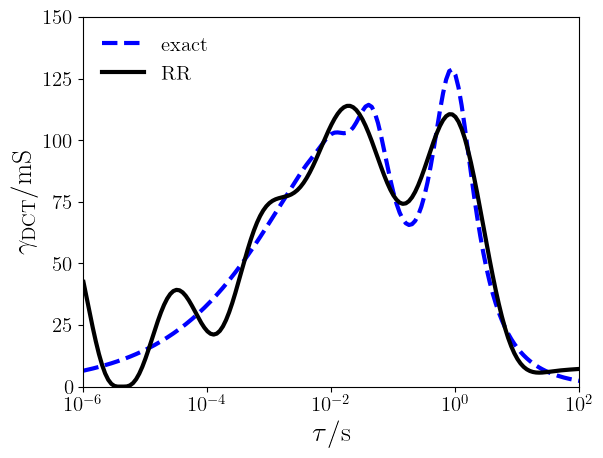

In [9]:
# DCT from RR
plt.semilogx(tau_vec, np.array(gamma_DCT_exact_list[0])*1000, '--', linewidth=3, color='blue', label='exact')
plt.semilogx(tau_vec, gamma_DCT_RR*1000, linewidth=3, color='black', label='RR')

plt.axis([1E-6, 1E2, 0, 150])
plt.yticks(np.arange(0, 150.01, 25))
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize = 20) 
plt.ylabel(r'$\gamma_{\rm DCT}/\rm mS$', fontsize = 20)
plt.show()

## 2.3 Nyquist plot of the experimental, exact, and RR-regressed admittances

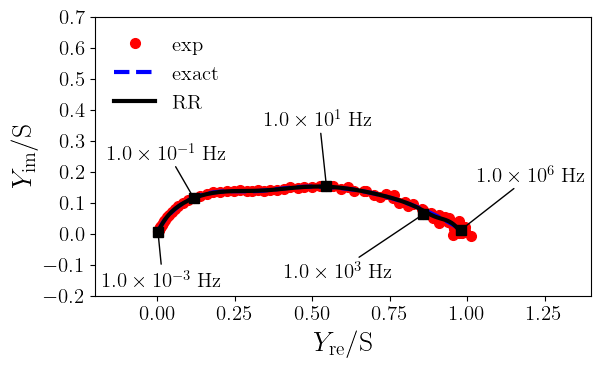

In [10]:
plt.plot(np.real(1/Z_exp_list[0]), np.imag(1/Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Y_exact_list[0]), np.imag(Y_exact_list[0]), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Y_RR), np.imag(Y_RR), linewidth=3, color='black', label='RR')
plt.plot(np.real(1/Z_exp_list[0][0]), np.imag(1/Z_exp_list[0][0]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][20]), np.imag(1/Z_exp_list[0][20]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][40]), np.imag(1/Z_exp_list[0][40]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][60]), np.imag(1/Z_exp_list[0][60]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][90]), np.imag(1/Z_exp_list[0][90]), 's', markersize=7, color='black')

plt.annotate(r'${1.0}\times 10^{-3} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][0]), np.imag(1/Z_exp_list[0][0])), 
                 xytext=(np.real(1/Z_exp_list[0][0])-0.18, -0.17+np.imag(1/Z_exp_list[0][0])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${1.0}\times 10^{-1} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][20]), np.imag(1/Z_exp_list[0][20])), 
                 xytext=(np.real(1/Z_exp_list[0][20])-0.28, 0.13+np.imag(1/Z_exp_list[0][20])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${1.0}\times 10^{1} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][40]), np.imag(1/Z_exp_list[0][40])), 
                 xytext=(np.real(1/Z_exp_list[0][40])-0.2, 0.2+np.imag(1/Z_exp_list[0][40])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${1.0}\times 10^{3} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][60]), np.imag(1/Z_exp_list[0][60])), 
                 xytext=(np.real(1/Z_exp_list[0][60])-0.45, -0.2+np.imag(1/Z_exp_list[0][60])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${1.0}\times 10^{6} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][90]), np.imag(1/Z_exp_list[0][90])), 
                 xytext=(np.real(1/Z_exp_list[0][90])+0.05, 0.16+np.imag(1/Z_exp_list[0][90])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.axis('scaled')
plt.xlim(-0.2, 1.4)
plt.ylim(-0.2, 0.7)
plt.yticks(np.arange(-0.2, 0.7001, 0.1))
plt.legend(frameon=False, fontsize = 15, loc='upper left')
plt.xlabel(r'$Y_{\rm re}/\rm S$', fontsize = 20)
plt.ylabel(r'$Y_{\rm im}/\rm S$', fontsize = 20)
plt.show()

# 3. Deep neural networks (DNNs)

## 3.1 Define the inputs of the DNNs

In [11]:
# define the reference conductance value, which acts as base
C_ref = 1E-5 
freq_times_Cref_torch = freq_vec_torch*C_ref

# list of experimental states, e.g., the temperature
T_min = 1
T_max = 6
delta_T = 1
T_range = np.arange(T_min, T_max, delta_T)

if T_min == T_max:
    T_range_norm = np.array([0.0])
else:
    T_range_norm = (T_range-T_min)/(T_max-T_min)

N_temps = len(T_range)

# lists of admittances and DCTs
Y_re_list, Y_im_list = [], []
YC_RR_list, gamma_RR_list = [], []

input_YC_NN = np.array([], dtype=np.float64).reshape(0, 1)
input_gamma_NN = np.array([], dtype=np.float64).reshape(0, 2)

for index, temp in enumerate(T_range):
    
    # experimental admittances
    Z_exp = Z_exp_list[index]
    Y_exp = 1/Z_exp
    Y_re = np.real(Y_exp)
    Y_im = np.imag(Y_exp)
    
    # convert the experimental and RR-regressed admittances to torch
    Y_re_torch = torch.from_numpy(Y_re.reshape(N_freqs,1)).type(Tensor)
    Y_im_torch = torch.from_numpy(Y_im.reshape(N_freqs,1)).type(Tensor)
    Y_re_list.append(Y_re_torch.detach())
    Y_im_list.append(Y_im_torch.detach())
    
    # prepare the pretraining step
    x_RR, gamma_RR, G_inf_RR, C_0_RR = compute_DCT.Simple_run(Z_exp, freq_vec, tau_vec, A_re_Y, A_im_Y, M_Y, lambda0)
    Y_RR = A_Y@x_RR
    Y_RR = Y_RR[0:N_freqs] + 1j*Y_RR[N_freqs:] 

    # convert to torch the conductance, G_inf_RR, and capacitance, C_0_RR, regressed with RR, and then save them in a list
    YC_RR_vec = torch.from_numpy(np.asarray([G_inf_RR, C_0_RR])).type(Tensor)
    YC_RR_list.append(YC_RR_vec.detach())
    
    # convert the DCT from RR in list storage
    gamma_RR_list.append(torch.from_numpy(gamma_RR.reshape(N_taus,1)).type(Tensor))
      
    # input for the GC-DNN that returns G_inf and C_0
    temp_loc = T_range_norm[index]
    input_YC_NN = np.vstack((input_YC_NN, temp_loc))
    
    # inputs for the gamma_DCT-DNN that returns the DCT
    temp_vec_loc = temp_loc*np.ones_like(log_tau_vec_norm)
    input_loc = np.hstack((temp_vec_loc, log_tau_vec_norm))
    input_gamma_NN = np.vstack((input_gamma_NN, input_loc))
    
    # data used in NN
    input_YC_NN_torch = torch.from_numpy(input_YC_NN).type(Tensor)
    input_gamma_NN_torch = torch.from_numpy(input_gamma_NN).type(Tensor)

     pcost       dcost       gap    pres   dres
 0: -4.2304e+01 -5.0970e+01  2e+02  1e+01  3e-05
 1: -4.1244e+01 -5.2797e+01  5e+01  4e+00  8e-06
 2: -4.1166e+01 -5.1707e+01  2e+01  6e-01  1e-06
 3: -4.2019e+01 -4.4263e+01  2e+00  6e-03  1e-08
 4: -4.2275e+01 -4.2540e+01  3e-01  4e-04  9e-10
 5: -4.2313e+01 -4.2346e+01  3e-02  1e-05  3e-11
 6: -4.2316e+01 -4.2321e+01  5e-03  1e-06  3e-12
 7: -4.2316e+01 -4.2317e+01  7e-04  2e-07  3e-13
 8: -4.2316e+01 -4.2317e+01  1e-04  1e-08  3e-14
 9: -4.2316e+01 -4.2317e+01  3e-05  2e-09  4e-15
10: -4.2316e+01 -4.2317e+01  3e-06  2e-16  7e-17
11: -4.2316e+01 -4.2316e+01  1e-07  1e-16  1e-16
12: -4.2316e+01 -4.2316e+01  2e-09  1e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2521e+01 -1.6843e+01  2e+02  1e+01  7e-05
 1: -1.1464e+01 -1.9020e+01  5e+01  3e+00  2e-05
 2: -1.1309e+01 -1.8532e+01  2e+01  6e-01  3e-06
 3: -1.2175e+01 -1.4572e+01  2e+00  6e-03  3e-08
 4: -1.2457e+01 -1.2786e+01  3e-01  6e-04  4e-0

## 3.2 Discretization and differentiation matrices

In [12]:
# discretization matrices
A_re_matrix = compute_DCT.A_re_ad(freq_vec, tau_vec)
A_im_matrix = compute_DCT.A_im_ad(freq_vec, tau_vec)

# differentiation matrix
L_matrix = compute_DCT.L(tau_vec)

# convert the matrices to torch
A_re_torch = torch.from_numpy(A_re_matrix).type(Tensor)
A_im_torch = torch.from_numpy(A_im_matrix).type(Tensor)
L_torch = torch.from_numpy(L_matrix).type(Tensor)

## 3.3 Define the parameters

In [13]:
# D_in is input dimension, H is the hidden dimension, D_out is output dimension
N_zeta = 0
D_in_gamma = 2 + N_zeta # this corresponds to tau and the temperature
D_in_YC = 1 # this corresponds to the temperature only
H_gamma = 50
H_YC = 10
D_out_gamma = 1
D_out_YC = 2

## 3.4 Architecture of the two DNNs

In [14]:
# architecture of the GC-DNN
class YC_NN(torch.nn.Module):
    def __init__(self):
        
        super(YC_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_YC, H_YC)
        self.fct_2 = torch.nn.Linear(H_YC, H_YC)
        self.fct_3 = torch.nn.Linear(H_YC, H_YC)
        self.fct_4 = torch.nn.Linear(H_YC, H_YC)
        self.fct_5 = torch.nn.Linear(H_YC, D_out_YC)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)

    def forward(self, freq):

        x = F.elu(self.fct_1(freq))
        x = F.elu(self.fct_2(x))
        x = F.elu(self.fct_3(x))
        x = F.elu(self.fct_4(x))
        gamma = F.softplus(self.fct_5(x))        
        
        return gamma

# architecture of the gamma_DCT-DNN
class gamma_NN(torch.nn.Module):
    def __init__(self):
        
        super(gamma_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_gamma, H_gamma)
        self.fct_2 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_3 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_4 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_5 = torch.nn.Linear(H_gamma, D_out_gamma)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)

    def forward(self, freq):

        x = F.elu(self.fct_1(freq))
        x = F.elu(self.fct_2(x))
        x = F.elu(self.fct_3(x))
        x = F.elu(self.fct_4(x))
        gamma = F.softplus(self.fct_5(x))        
        
        return gamma

## 3.5 Loss function defined in (29)

In [15]:
def loss_fn(YC_NN_output, gamma_NN_output, YC_RR_list, gamma_RR_list, Y_re_list, Y_im_list):
    
    loss, MSE_Z = 0, 0
    
    for index in range(len(T_range)):
        
        # unpack the neural network output
        G_inf = YC_NN_output[index, 0]
        C_0 = YC_NN_output[index, 1]
        G_inf_RR = YC_RR_list[index][0]
        C_0_RR = YC_RR_list[index][1]/C_ref
        
        # unpack gamma
        index_unpack = range(index*N_taus, (index+1)*N_taus)
        gamma = gamma_NN_output[index_unpack,0].reshape(N_taus,1)

        # external data
        Y_re = Y_re_list[index]
        Y_im = Y_im_list[index]
                
        MSE_re = torch.sum((G_inf + torch.matmul(A_re_torch, gamma) - Y_re)**2)
        MSE_im = torch.sum((2.*np.pi*freq_times_Cref_torch*C_0 + torch.matmul(A_im_torch, gamma) - Y_im)**2)
        MSE_YC = torch.sum((torch.hstack((G_inf_RR, C_0_RR)) - YC_NN_output[index])**2)
        MSE_gamma = torch.sum((gamma - gamma_RR_list[index])**2)
        MSE_Z += MSE_re + MSE_im
        loss += MSE_re + MSE_im + MSE_gamma + MSE_YC
    
    return loss, MSE_Z

model_gamma = gamma_NN()
model_YC = YC_NN()
if cuda:
    model_gamma.cuda()
    model_YC.cuda()

## 3.6 Training of the DNNs

In [16]:
# we use Adam algorithm with a learning rate of 10**(-5)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model_gamma.parameters(), lr=learning_rate)
optimizer.add_param_group({"params": model_YC.parameters()})

# maximum number of iterations
max_iters = 100001

# optimize the neural network
loss_vec = []

gamma_NN_store = torch.zeros((max_iters, N_taus, N_temps)).type(Tensor)
G_inf_NN_store = torch.zeros((max_iters, N_temps)).type(Tensor)
C_0_NN_store = torch.zeros((max_iters, N_temps)).type(Tensor)

for t in range(max_iters):
    
    # forward pass: compute predicted y by passing x to the model
    gamma_NN_output = model_gamma(input_gamma_NN_torch)
    YC_NN_output = model_YC(input_YC_NN_torch)
    
    # compute the loss
    loss, MSE = loss_fn(YC_NN_output, gamma_NN_output, YC_RR_list, gamma_RR_list, Y_re_list, Y_im_list)
    
    # save it
    loss_vec.append([t, MSE.item()])
    
    # store gamma
    gamma_NN_store[t, :] = gamma_NN_output.detach().reshape(N_temps, N_taus).T
    
    # store G_inf
    G_inf_NN_store[t,:] = YC_NN_output[:,0].detach()

    # store C_0
    C_0_NN_store[t, :] = YC_NN_output[:,1].detach()

    # print the iteration and loss value
    if not t%500:
        print('iter=%d; loss=%e' % (t, MSE.item()))
        
    optimizer.zero_grad()

    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # optimizing the DNN parameters
    optimizer.step()

iter=0; loss=5.588219e+04
iter=500; loss=3.657459e+04
iter=1000; loss=2.405707e+04
iter=1500; loss=1.632966e+04
iter=2000; loss=1.157553e+04
iter=2500; loss=8.487757e+03
iter=3000; loss=6.372261e+03
iter=3500; loss=4.860929e+03
iter=4000; loss=3.747139e+03
iter=4500; loss=2.908521e+03
iter=5000; loss=2.267778e+03
iter=5500; loss=1.773831e+03
iter=6000; loss=1.390809e+03
iter=6500; loss=1.092622e+03
iter=7000; loss=8.597725e+02
iter=7500; loss=6.775397e+02
iter=8000; loss=5.347021e+02
iter=8500; loss=4.226454e+02
iter=9000; loss=3.346914e+02
iter=9500; loss=2.656190e+02
iter=10000; loss=2.113350e+02
iter=10500; loss=1.686251e+02
iter=11000; loss=1.349634e+02
iter=11500; loss=1.083619e+02
iter=12000; loss=8.725443e+01
iter=12500; loss=7.041442e+01
iter=13000; loss=5.690755e+01
iter=13500; loss=4.603767e+01
iter=14000; loss=3.727843e+01
iter=14500; loss=3.024297e+01
iter=15000; loss=2.462990e+01
iter=15500; loss=2.018200e+01
iter=16000; loss=1.667987e+01
iter=16500; loss=1.392873e+01
iter

## 3.7 Number of parameters for each DNN

In [17]:
print('total number parameters of the GC-DNN = ', compute_DCT.count_parameters(model_gamma),'>>', N_freqs)
print('total number parameters of the gamma_DCT-DNN = ', compute_DCT.count_parameters(model_YC),'>>', N_freqs)

total number parameters of the GC-DNN =  7851 >> 91
total number parameters of the gamma_DCT-DNN =  372 >> 91


## 3.8 Plot of the DNN loss (Figure S9 (c) in the Supplementary Information Part 2)

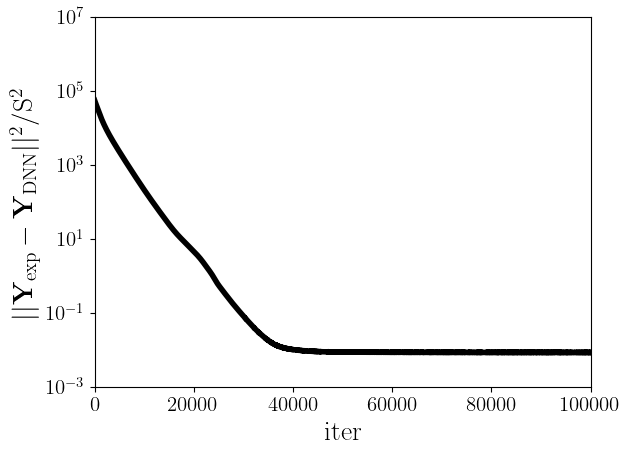

In [18]:
plt.semilogy(np.asarray(loss_vec)[:,0], np.asarray(loss_vec)[:,1], linewidth=4, color="black")

plt.xlim(0, 1E5)
plt.ylim(1E-3, 1E7)
plt.xlabel(r'iter', fontsize=20)
plt.ylabel(r'$|| \mathbf Y_{\rm exp} - \mathbf Y_{\rm DNN} ||^{2}/\rm S^{2}$', fontsize=20)
plt.show()

# 4. Recover the DCTs and admittances

## 4.1 Outputs of the DNNs

In [19]:
gamma_DNN_list = [0]*N_exp # list of DNN-regressed DCTs
Y_DNN_list = [0]*N_exp # list of DNN-regressed admittances
Z_DNN_list = [0]*N_exp # list of DNN-regressed impedances

for index in range(N_temps):
    
    # real and imaginary parts of the DNN-regressed admittance
    gamma = gamma_NN_output[index*N_taus:(index+1)*N_taus]
    G_inf = YC_NN_output[index, 0]
    C_0 = YC_NN_output[index, 1]
    Y_re = (G_inf + torch.matmul(A_re_torch, gamma)).detach().cpu().numpy()
    Y_im = (2.*np.pi*freq_times_Cref_torch*C_0 + torch.matmul(A_im_torch, gamma)).detach().cpu().numpy()
    Y_DNN_list[index] = Y_re + 1j*Y_im
    Z_DNN_list[index] = 1/Y_DNN_list[index]
    
    # DNN-regressed DCT
    gamma_DNN_list[index] = gamma_NN_output[index*N_taus:(index+1)*N_taus].detach().cpu().numpy()

## 4.2 Nyquist plot of the experimental, exact, and DNN-regressed impedances

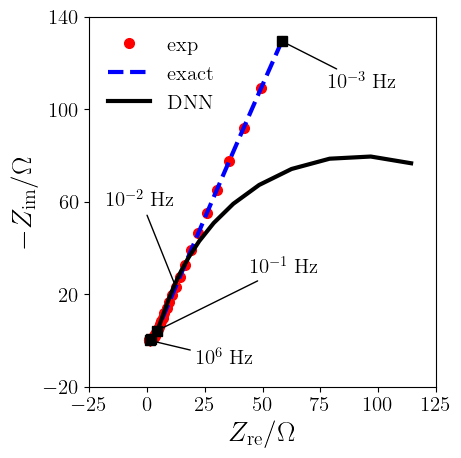

In [20]:
plt.plot(np.real(Z_exp_list[0]), -np.imag(Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Z_exact_list[0]), -np.imag(Z_exact_list[0]), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DNN_list[0]), -np.imag(Z_DNN_list[0]), linewidth=3, color='black', label='DNN')
plt.plot(np.real(Z_exp_list[0][0]), -np.imag(Z_exp_list[0][0]), 's', markersize=7, color='black')
plt.plot(np.real(Z_exp_list[0][20]), -np.imag(Z_exp_list[0][20]), 's', markersize=7, color='black')
plt.plot(np.real(Z_exp_list[0][40]), -np.imag(Z_exp_list[0][40]), 's', markersize=7, color='black')
plt.plot(np.real(Z_exp_list[0][80]), -np.imag(Z_exp_list[0][80]), 's', markersize=7, color='black')

plt.annotate(r'$10^{-3} \; \rm{Hz}$', xy=(np.real(Z_exp_list[0][0]), -np.imag(Z_exp_list[0][0])), 
                 xytext=(np.real(Z_exp_list[0][0])+20, -20-np.imag(Z_exp_list[0][0])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-2} \; \rm{Hz}$', xy=(np.real(Z_exp_list[0][10]), -np.imag(Z_exp_list[0][10])), 
                 xytext=(np.real(Z_exp_list[0][10])-30, 35-np.imag(Z_exp_list[0][10])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-1} \; \rm{Hz}$', xy=(np.real(Z_exp_list[0][20]), -np.imag(Z_exp_list[0][20])), 
                 xytext=(np.real(Z_exp_list[0][20])+40, 25-np.imag(Z_exp_list[0][20])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{6} \; \rm{Hz}$', xy=(np.real(Z_exp_list[0][80]), -np.imag(Z_exp_list[0][80])), 
                 xytext=(np.real(Z_exp_list[0][80])+20, -10-np.imag(Z_exp_list[0][80])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.axis('scaled')
plt.xlim(-25, 125)
plt.ylim(-20, 140)
plt.xticks(np.arange(-25, 125.001, 25))
plt.yticks(np.arange(-20, 140.001, 40))
plt.legend(frameon=False, fontsize = 15, loc='upper left')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 4.3 Nyquist plots of the experimental, exact, and DNN-regressed admittances

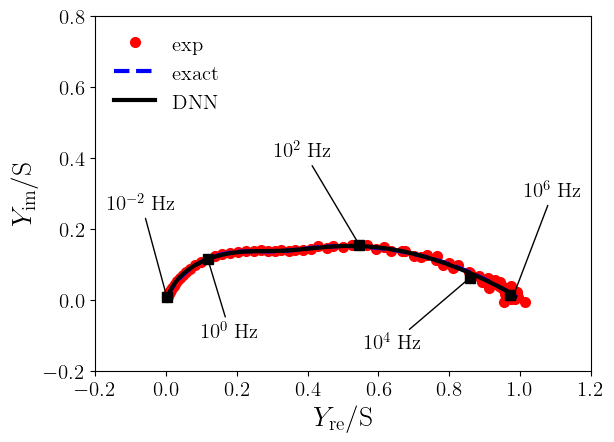

In [21]:
plt.plot(np.real(1/Z_exp_list[0]), np.imag(1/Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Y_exact_list[0]), np.imag(Y_exact_list[0]), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Y_DNN_list[0]), np.imag(Y_DNN_list[0]), linewidth=3, color='black', label='DNN')
plt.plot(np.real(1/Z_exp_list[0][0]), np.imag(1/Z_exp_list[0][0]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][20]), np.imag(1/Z_exp_list[0][20]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][40]), np.imag(1/Z_exp_list[0][40]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][60]), np.imag(1/Z_exp_list[0][60]), 's', markersize=7, color='black')
plt.plot(np.real(1/Z_exp_list[0][80]), np.imag(1/Z_exp_list[0][80]), 's', markersize=7, color='black')

plt.annotate(r'$10^{-2} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][0]), np.imag(1/Z_exp_list[0][0])), 
                 xytext=(np.real(1/Z_exp_list[0][0])-0.17, 0.25+np.imag(1/Z_exp_list[0][0])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{0} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][20]), np.imag(1/Z_exp_list[0][20])), 
                 xytext=(np.real(1/Z_exp_list[0][20])-0.02, -0.22+np.imag(1/Z_exp_list[0][20])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{2} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][40]), np.imag(1/Z_exp_list[0][40])), 
                 xytext=(np.real(1/Z_exp_list[0][40])-0.24, 0.25+np.imag(1/Z_exp_list[0][40])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{4} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][60]), np.imag(1/Z_exp_list[0][60])), 
                 xytext=(np.real(1/Z_exp_list[0][60])-0.3, -0.2+np.imag(1/Z_exp_list[0][60])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{6} \; \rm{Hz}$', xy=(np.real(1/Z_exp_list[0][90]), np.imag(1/Z_exp_list[0][90])), 
                 xytext=(np.real(1/Z_exp_list[0][90])+0.03, 0.28+np.imag(1/Z_exp_list[0][90])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.axis('scaled')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 0.8)
plt.legend(frameon=False, fontsize = 15, loc='upper left')
plt.xlabel(r'$Y_{\rm re}/\rm S$', fontsize = 20)
plt.ylabel(r'$Y_{\rm im}/\rm S$', fontsize = 20)
plt.show()

## 4.4 Plot of the exact and DNN-regressed DCTs (Figure S16 (a) in the Supplementary Information Part 2)

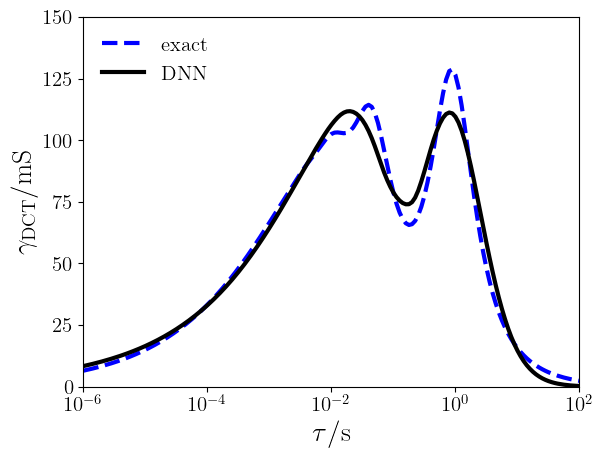

In [22]:
plt.semilogx(tau_vec, np.array(gamma_DCT_exact_list[0])*1000, '--', linewidth=3, color='blue', label='exact')
plt.semilogx(tau_vec, gamma_DNN_list[0]*1000, linewidth=3, color='black', label='DNN')

plt.axis([1E-6, 1E2, 0, 150])
plt.yticks(np.arange(0, 150.01, 25))
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize = 20) 
plt.ylabel(r'$\gamma_{\rm DCT}/\rm mS$', fontsize = 20)
plt.show()

## 4.5 Bode plots of the experimental, exact, and DNN-regressed impedances (Figure S16 (c) in the Supplementary Information Part 2)

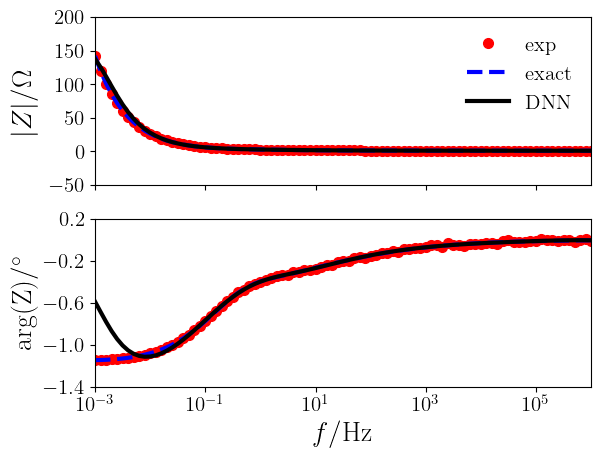

In [23]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.semilogx(freq_vec, np.abs(Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, np.abs(Z_exact_list[0]), '--', linewidth=3, color='blue', label='exact')
ax1.semilogx(freq_vec, np.abs(Z_DNN_list[0]), linewidth=3, color='black', label='DNN')
ax1.axis([1E-3, 1E6, -50, 200])
ax1.set_yticks(np.arange(-50, 200.01, step=50)) 
ax1.legend(frameon=False, fontsize = 15)
ax1.set_ylabel(r'$| Z |/\Omega$', fontsize = 20)

ax2.semilogx(freq_vec, np.angle(Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec, np.angle(Z_exact_list[0]), '--', linewidth=3, color='blue', label='exact')
ax2.semilogx(freq_vec, np.angle(Z_DNN_list[0]), linewidth=3, color='black', label='DNN')
ax2.axis([1E-3, 1E6, -1.4, 0.2])
ax2.set_yticks(np.arange(-1.4, 0.201, step=0.4))
ax2.set_ylabel(r'$\rm arg(Z)/^\circ$', fontsize = 20)

plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.align_ylabels()
plt.show()

## 4.6 Bode plots of the experimental, exact, and DNN-regressed admittances (Figure S16 (b) in the Supplementary Information Part 2)

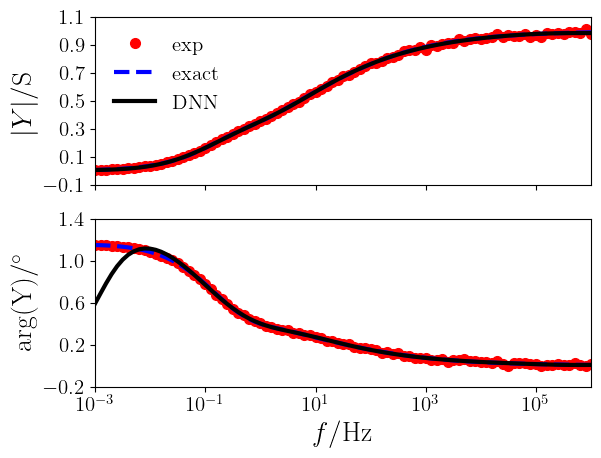

In [24]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.semilogx(freq_vec, np.abs(1/Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, np.abs(Y_exact_list[0]), '--', linewidth=3, color='blue', label='exact')
ax1.semilogx(freq_vec, np.abs(Y_DNN_list[0]), linewidth=3, color='black', label='DNN')
ax1.set_ylabel(r'$| Y |/\rm S$', fontsize = 20)
ax1.axis([1E-3, 1E6, -0.1, 1.1])
ax1.legend(frameon=False, fontsize = 15, loc='upper left')
ax1.set_yticks(np.arange(-0.1, 1.101, step=0.2)) 

ax2.semilogx(freq_vec, np.angle(1/Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec, np.angle(Y_exact_list[0]), '--', linewidth=3, color='blue', label='exact')
ax2.semilogx(freq_vec, np.angle(Y_DNN_list[0]), linewidth=3, color='black', label='DNN')
ax2.set_ylabel(r'$\rm arg(Y)/^\circ$', fontsize = 20)
ax2.axis([1E-3, 1E6, -0.2, 1.4])
ax2.set_yticks(np.arange(-0.2, 1.401, step=0.4)) 

plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.align_ylabels()
plt.show()

# 5. Waterfall plot (Figure 10 (c))

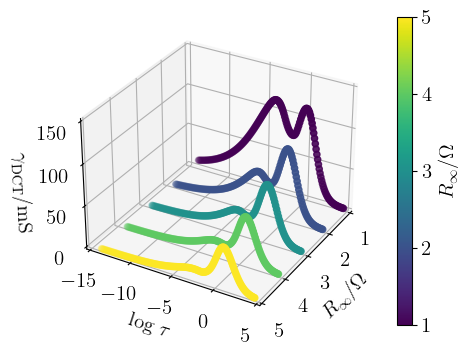

In [25]:
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize = (6.472, 4))
ax = plt.axes(projection ="3d")
ax.scatter3D(R_inf_list[0], np.log(tau_vec), gamma_DNN_list[0]*1000, color = cmap.colors[0])
ax.scatter3D(R_inf_list[1], np.log(tau_vec), gamma_DNN_list[1]*1000, color = cmap.colors[64])
ax.scatter3D(R_inf_list[2], np.log(tau_vec), gamma_DNN_list[2]*1000, color = cmap.colors[128])
ax.scatter3D(R_inf_list[3], np.log(tau_vec), gamma_DNN_list[3]*1000, color = cmap.colors[192])
ax.scatter3D(R_inf_list[4], np.log(tau_vec), gamma_DNN_list[4]*1000, color = cmap.colors[255])
ax.set_xlim(1, 5) # R_ion
ax.set_ylim(-15, 5) # log tau
ax.set_zlim(0*1000, 0.15*1000) # gamma_DCT
ax.set_xlabel(r'$R_{\infty}/\Omega$')
ax.set_ylabel(r'$\rm log \; \tau$')
ax.set_zlabel(r'$\gamma_{\rm DCT}/\rm mS$')
ax.azim = 30
ax.elev = 30
norm = mpl.colors.Normalize(vmin=1, vmax=5)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label=r'$R_{\infty}/\Omega$')
plt.show()

# 6. Contour plot (Figure 10 (d))

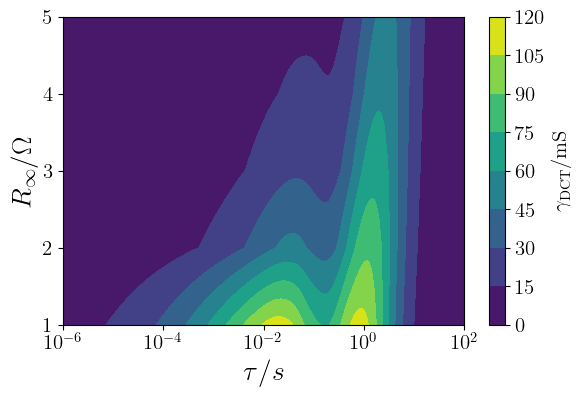

In [26]:
psi_vec = np.array(T_range_norm, dtype=float)
temp_vec = np.array(R_inf_list, dtype=float)
tau_mat, temp_mat = np.meshgrid(tau_vec, temp_vec)

# DCT matrix that encapsulates the dependence on the experimental conditions
gamma_global_mat = np.zeros((len(R_inf_list), len(tau_vec)))
for index, temp in enumerate(R_inf_list):
    gamma_global_mat[index, :] = gamma_DNN_list[index].reshape(N_taus)*1000

fig = plt.figure(figsize=(6.472, 4)) 
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.5)
ax = plt.subplot(gs[0,0])
cs = ax.contourf(tau_mat, temp_mat, gamma_global_mat, cmap=plt.cm.viridis)
levels = np.array([0.1, 0.3]) 
fig.colorbar(cs, label=r'$\gamma_{\rm DCT}/\rm mS$')
ax.set_ylabel(r'$R_{\infty}/\Omega$', fontsize = 20)
ax.set_xlabel(r'$\tau/s$', fontsize = 20)
ax.set_xscale('log')
plt.show()